# In this notebook, we are going to implement MLP model to analysis the data
## https://en.wikipedia.org/wiki/Convolutional_neural_network


In [1]:
import os
import math
import random
from glob import glob
from PIL import Image

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import Dropout,Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split

# Load metadata.csv

In [2]:
df = pd.read_csv('../data/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

# Preprocess labels

In [3]:
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx dx_type   age     sex     localization  \
7337  HAM_0005106  ISIC_0032901   nv   histo  30.0    male  upper extremity   
7875  HAM_0001883  ISIC_0033224   nv   histo  30.0  female             back   
7022  HAM_0003175  ISIC_0028145   nv   histo   5.0    male  lower extremity   
7110  HAM_0001192  ISIC_0033859   nv   histo  50.0  female             foot   
270   HAM_0004491  ISIC_0025157  bkl   histo  45.0    male             face   

      label  
7337      5  
7875      5  
7022      5  
7110      5  
270       2  


# Features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [4]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df", 4:"mel",5:"nv",6:"vasc"}

In [5]:
#assign weight
#sum of the data
total_data = 0
num_classes = 7
for num_of_data in df['label'].value_counts():
    total_data+=num_of_data
print("total number of data: ",total_data)
print(df['label'].value_counts())
#calc weight for each class
class_weight ={}
for index, value in df.label.value_counts().iteritems():
    v1 = math.log(total_data/(float(value)*num_classes))
    class_weight[index] = v1 if v1>1.0 else 1.0

for i in class_weight:
    print(i," ",class_weight[i])

total number of data:  10015
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
5   1.0
4   1.0
2   1.0
1   1.0237058335894402
0   1.4759689281473518
6   2.310102041443345
3   2.520996970681355


In [6]:
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('../data/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [7]:
#image_64 is the actual image(resized to 64x64) store in the dataframe
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

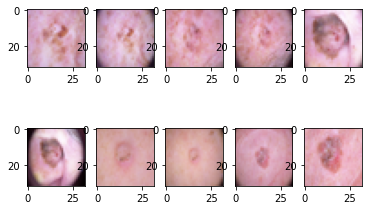

In [8]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [9]:
#image to array
df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
data = data.reshape(total_data,image_size*image_size*3).astype('float32')
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)
#80% data for training
#20% data for testing
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=87,stratify=label_to_one_hot)


# Model Building

In [10]:
#setup MLP model
num_classes = 7
dimension = image_size*image_size*3

model_MLP_V1 = Sequential()

#input Dense layer of 64x64x3 image input:
#with normal distribution + relu activation
model_MLP_V1.add(Dense(units=2048,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V1.add(Dropout(0.1))

#hidden layer 2
model_MLP_V1.add(Dense(units=1024,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V1.add(Dropout(0.1))

#hidden layer 3
model_MLP_V1.add(Dense(units=512,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V1.add(Dropout(0.1))

#hidden layer 4
model_MLP_V1.add(Dense(units=256,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V1.add(Dropout(0.1))

#output Dense layer with 7 classes + softmax activation
model_MLP_V1.add(Dense(units=num_classes,kernel_initializer='normal',activation='softmax'))
model_MLP_V1.summary()

model_MLP_V1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1

In [11]:
# Train
try:
    model_MLP_V1.load_weights('../models/MLP_weight.h5')
except:
    print("new model_MLP_V1")

batch_size = 512
epochs = 200

train_history = model_MLP_V1.fit(
    x=train_data,y=train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2,class_weight=class_weight)

Epoch 1/200
13/13 - 5s - loss: 1.3145 - acc: 0.6673 - val_loss: 0.9246 - val_acc: 0.6800
Epoch 2/200
13/13 - 2s - loss: 0.9436 - acc: 0.7088 - val_loss: 0.8423 - val_acc: 0.6887
Epoch 3/200
13/13 - 2s - loss: 0.8297 - acc: 0.7344 - val_loss: 0.8324 - val_acc: 0.6987
Epoch 4/200
13/13 - 3s - loss: 0.7455 - acc: 0.7474 - val_loss: 0.8117 - val_acc: 0.7080
Epoch 5/200
13/13 - 2s - loss: 0.6989 - acc: 0.7649 - val_loss: 0.7843 - val_acc: 0.7174
Epoch 6/200
13/13 - 2s - loss: 0.6652 - acc: 0.7730 - val_loss: 0.8020 - val_acc: 0.7037
Epoch 7/200
13/13 - 2s - loss: 0.6606 - acc: 0.7755 - val_loss: 0.7840 - val_acc: 0.7249
Epoch 8/200
13/13 - 3s - loss: 0.6415 - acc: 0.7767 - val_loss: 0.7985 - val_acc: 0.7180
Epoch 9/200
13/13 - 3s - loss: 0.6477 - acc: 0.7752 - val_loss: 0.7728 - val_acc: 0.7205
Epoch 10/200
13/13 - 3s - loss: 0.6414 - acc: 0.7764 - val_loss: 0.7909 - val_acc: 0.7180
Epoch 11/200
13/13 - 3s - loss: 0.6296 - acc: 0.7820 - val_loss: 0.8025 - val_acc: 0.7280
Epoch 12/200
13/13 

13/13 - 2s - loss: 0.4041 - acc: 0.8591 - val_loss: 0.9160 - val_acc: 0.7087
Epoch 93/200
13/13 - 2s - loss: 0.4174 - acc: 0.8452 - val_loss: 0.9208 - val_acc: 0.7024
Epoch 94/200
13/13 - 2s - loss: 0.4019 - acc: 0.8577 - val_loss: 0.8998 - val_acc: 0.7087
Epoch 95/200
13/13 - 2s - loss: 0.3657 - acc: 0.8689 - val_loss: 0.9407 - val_acc: 0.7155
Epoch 96/200
13/13 - 2s - loss: 0.3848 - acc: 0.8624 - val_loss: 0.9388 - val_acc: 0.7118
Epoch 97/200
13/13 - 2s - loss: 0.3650 - acc: 0.8707 - val_loss: 0.9340 - val_acc: 0.7080
Epoch 98/200
13/13 - 2s - loss: 0.3653 - acc: 0.8677 - val_loss: 0.9676 - val_acc: 0.7087
Epoch 99/200
13/13 - 2s - loss: 0.3734 - acc: 0.8653 - val_loss: 0.9841 - val_acc: 0.7031
Epoch 100/200
13/13 - 2s - loss: 0.3811 - acc: 0.8650 - val_loss: 0.9837 - val_acc: 0.6956
Epoch 101/200
13/13 - 2s - loss: 0.4106 - acc: 0.8566 - val_loss: 0.9331 - val_acc: 0.7211
Epoch 102/200
13/13 - 3s - loss: 0.4024 - acc: 0.8540 - val_loss: 0.9332 - val_acc: 0.7049
Epoch 103/200
13/13 

Epoch 183/200
13/13 - 3s - loss: 0.2720 - acc: 0.9040 - val_loss: 1.1281 - val_acc: 0.6918
Epoch 184/200
13/13 - 2s - loss: 0.2972 - acc: 0.8978 - val_loss: 1.1109 - val_acc: 0.6900
Epoch 185/200
13/13 - 3s - loss: 0.2761 - acc: 0.9047 - val_loss: 1.1182 - val_acc: 0.7068
Epoch 186/200
13/13 - 3s - loss: 0.3221 - acc: 0.8869 - val_loss: 1.0411 - val_acc: 0.6974
Epoch 187/200
13/13 - 3s - loss: 0.2984 - acc: 0.8981 - val_loss: 1.0860 - val_acc: 0.6993
Epoch 188/200
13/13 - 3s - loss: 0.2903 - acc: 0.9005 - val_loss: 1.0901 - val_acc: 0.7056
Epoch 189/200
13/13 - 2s - loss: 0.2977 - acc: 0.8966 - val_loss: 1.1210 - val_acc: 0.6937
Epoch 190/200
13/13 - 3s - loss: 0.2776 - acc: 0.9064 - val_loss: 1.0369 - val_acc: 0.7006
Epoch 191/200
13/13 - 2s - loss: 0.3122 - acc: 0.8955 - val_loss: 1.1056 - val_acc: 0.6875
Epoch 192/200
13/13 - 2s - loss: 0.2846 - acc: 0.9061 - val_loss: 1.0292 - val_acc: 0.6968
Epoch 193/200
13/13 - 3s - loss: 0.2681 - acc: 0.9070 - val_loss: 1.0898 - val_acc: 0.7012

In [12]:
model_MLP_V1.save_weights('../models/MLP_weight.h5')
model_MLP_V1.save('../models/MLP_V1.h5')

In [13]:
# apply oversampling instead of class weight
smote_sample = SMOTE(random_state=87)
train_data_oversample, train_label_oversample = smote_sample.fit_resample(train_data, train_label)

/Users/skylan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [14]:
#setup MLP model V2
num_classes = 7
dimension = image_size*image_size*3

model_MLP_V2 = Sequential()

#input Dense layer of 64x64x3 image input:
#with normal distribution + relu activation
model_MLP_V2.add(Dense(units=2048,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V2.add(Dropout(0.2))

#hidden layer 2
model_MLP_V2.add(Dense(units=1024,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V2.add(Dropout(0.3))

#hidden layer 3
model_MLP_V2.add(Dense(units=512,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V2.add(Dropout(0.3))

#hidden layer 4
model_MLP_V2.add(Dense(units=256,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V2.add(Dropout(0.3))

#output Dense layer with 7 classes + softmax activation
model_MLP_V2.add(Dense(units=num_classes,kernel_initializer='normal',activation='softmax'))
model_MLP_V2.summary()

model_MLP_V2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

In [15]:
# Train
try:
    model_MLP_V2.load_weights('../models/MLP_V2_weight.h5')
except:
    print("new model_MLP_V2")

batch_size = 512
epochs = 200

train_history_2 = model_MLP_V2.fit(
    x=train_data_oversample,y=train_label_oversample,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2, shuffle=True)

new model_MLP_V2
Epoch 1/200
59/59 - 14s - loss: 2.1772 - acc: 0.1905 - val_loss: 3.5627 - val_acc: 0.0000e+00
Epoch 2/200
59/59 - 13s - loss: 1.6831 - acc: 0.2829 - val_loss: 4.2785 - val_acc: 0.0000e+00
Epoch 3/200
59/59 - 12s - loss: 1.5741 - acc: 0.3213 - val_loss: 3.9693 - val_acc: 0.0997
Epoch 4/200
59/59 - 13s - loss: 1.5124 - acc: 0.3598 - val_loss: 4.1298 - val_acc: 0.1498
Epoch 5/200
59/59 - 12s - loss: 1.4732 - acc: 0.3762 - val_loss: 4.5029 - val_acc: 0.1084
Epoch 6/200
59/59 - 12s - loss: 1.4472 - acc: 0.3969 - val_loss: 4.0026 - val_acc: 0.1055
Epoch 7/200
59/59 - 12s - loss: 1.4255 - acc: 0.4115 - val_loss: 3.9753 - val_acc: 0.1156
Epoch 8/200
59/59 - 11s - loss: 1.4024 - acc: 0.4298 - val_loss: 3.9214 - val_acc: 0.1814
Epoch 9/200
59/59 - 12s - loss: 1.3407 - acc: 0.4596 - val_loss: 3.9033 - val_acc: 0.1550
Epoch 10/200
59/59 - 12s - loss: 1.3274 - acc: 0.4673 - val_loss: 4.1337 - val_acc: 0.1547
Epoch 11/200
59/59 - 12s - loss: 1.3387 - acc: 0.4664 - val_loss: 4.2528 -

Epoch 91/200
59/59 - 11s - loss: 0.7665 - acc: 0.7081 - val_loss: 3.8658 - val_acc: 0.1855
Epoch 92/200
59/59 - 10s - loss: 0.7277 - acc: 0.7261 - val_loss: 3.4384 - val_acc: 0.1874
Epoch 93/200
59/59 - 10s - loss: 0.7467 - acc: 0.7186 - val_loss: 3.9076 - val_acc: 0.1714
Epoch 94/200
59/59 - 10s - loss: 0.7433 - acc: 0.7227 - val_loss: 3.7298 - val_acc: 0.1631
Epoch 95/200
59/59 - 10s - loss: 0.7223 - acc: 0.7284 - val_loss: 3.8983 - val_acc: 0.1470
Epoch 96/200
59/59 - 10s - loss: 0.7245 - acc: 0.7271 - val_loss: 3.9420 - val_acc: 0.1286
Epoch 97/200
59/59 - 10s - loss: 0.7235 - acc: 0.7303 - val_loss: 3.5890 - val_acc: 0.1664
Epoch 98/200
59/59 - 11s - loss: 0.7471 - acc: 0.7192 - val_loss: 3.7740 - val_acc: 0.1470
Epoch 99/200
59/59 - 11s - loss: 0.7481 - acc: 0.7172 - val_loss: 3.4328 - val_acc: 0.1682
Epoch 100/200
59/59 - 11s - loss: 0.7426 - acc: 0.7201 - val_loss: 3.8268 - val_acc: 0.1302
Epoch 101/200
59/59 - 11s - loss: 0.7104 - acc: 0.7334 - val_loss: 3.6249 - val_acc: 0.17

Epoch 181/200
59/59 - 13s - loss: 0.7581 - acc: 0.7126 - val_loss: 3.7807 - val_acc: 0.1542
Epoch 182/200
59/59 - 14s - loss: 0.7542 - acc: 0.7123 - val_loss: 4.1797 - val_acc: 0.1348
Epoch 183/200
59/59 - 13s - loss: 0.7383 - acc: 0.7178 - val_loss: 3.8175 - val_acc: 0.1594
Epoch 184/200
59/59 - 12s - loss: 0.8111 - acc: 0.6955 - val_loss: 3.7829 - val_acc: 0.1615
Epoch 185/200
59/59 - 12s - loss: 0.7428 - acc: 0.7175 - val_loss: 4.1984 - val_acc: 0.1646
Epoch 186/200
59/59 - 12s - loss: 0.7576 - acc: 0.7140 - val_loss: 3.8636 - val_acc: 0.1639
Epoch 187/200
59/59 - 13s - loss: 0.6627 - acc: 0.7489 - val_loss: 3.8186 - val_acc: 0.1884
Epoch 188/200
59/59 - 13s - loss: 0.6927 - acc: 0.7376 - val_loss: 3.4394 - val_acc: 0.1639
Epoch 189/200
59/59 - 14s - loss: 0.6882 - acc: 0.7378 - val_loss: 3.8306 - val_acc: 0.1798
Epoch 190/200
59/59 - 13s - loss: 0.6828 - acc: 0.7412 - val_loss: 3.6882 - val_acc: 0.1917
Epoch 191/200
59/59 - 13s - loss: 0.6954 - acc: 0.7350 - val_loss: 3.8232 - val_

In [16]:
model_MLP_V2.save_weights('../models/MLP_V2_weight.h5')
model_MLP_V2.save('../models/MLP_V2.h5')

# Model Evaluation

In [17]:
def plot_model_accuracy(train_history, path):
    plt.plot(train_history.history['acc'])
    plt.plot(train_history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.savefig(path)
    plt.show()
    
def plot_model_loss(train_history, path):
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.savefig(path)
    plt.show()

MLP V1


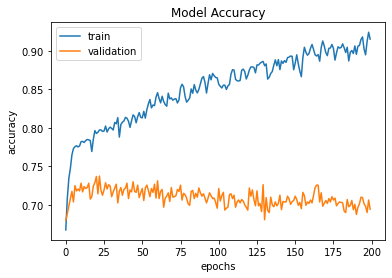

MLP V2


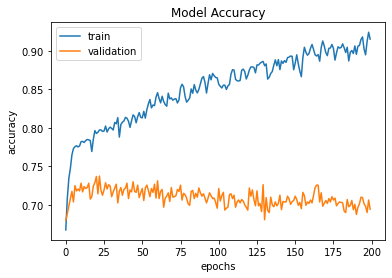

In [18]:
#plot train history
print("MLP V1")
plot_model_accuracy(train_history,'../plots/MLP_V1_training_history.jpg')
print("MLP V2")
plot_model_accuracy(train_history,'../plots/MLP_V2_training_history.jpg')

MLP V1


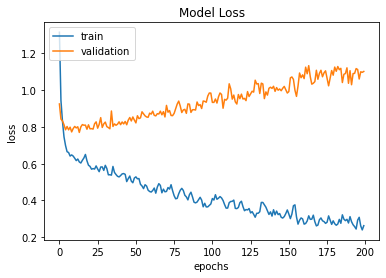

MLP V2


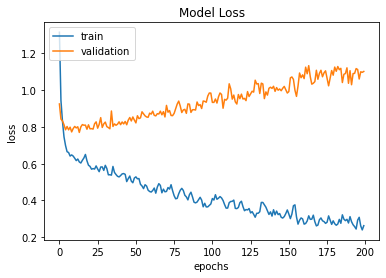

In [20]:
# plot loss
print("MLP V1")
plot_model_loss(train_history, '../plots/MLP_V1_training_loss.jpg')
print("MLP V2")
plot_model_loss(train_history, '../plots/MLP_V2_training_loss.jpg')

In [21]:
#score
score = model_MLP_V1.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

score_2 = model_MLP_V2.evaluate(test_data, test_label)
print('Test accuracy:', score_2[1])

63/63 [==============================] - 1s 13ms/step - loss: 1.2031 - acc: 0.6965
Test accuracy: 0.6964552998542786
63/63 [==============================] - 1s 14ms/step - loss: 1.1744 - acc: 0.5272
Test accuracy: 0.5272091627120972


In [22]:
#predictions
print("MLP V1")
prediction = model_MLP_V1.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))

print("MLP V2")
prediction_2 = model_MLP_V2.predict(test_data)

prediction_class_2 = np.argmax(prediction_2,axis=1)
prediction_label_2 = np.argmax(test_label,axis=1)

#confusion matrix
mapping = lambda x:features_dict[x]
pred_class_to_feature_2 = np.array([mapping(x) for x in prediction_class_2])
pred_label_to_feature_2 = np.array([mapping(x) for x in prediction_label_2])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature_2,pred_class_to_feature_2,rownames=['actual'],colnames=['predicted']))

MLP V1
predicted  akiex  bcc  bkl  df  mel    nv  vasc
actual                                         
akiex         15   12   14   4   10    10     0
bcc           18   42    8   4    7    20     4
bkl           10    7  100   4   27    69     3
df             5    5    4   3    0     6     0
mel            7    7   37   2   59   109     2
nv             8   16   76   4   70  1164     3
vasc           0    3    2   1    3     7    12
MLP V2
predicted  akiex  bcc  bkl  df  mel   nv  vasc
actual                                        
akiex         15   10   22   4    9    5     0
bcc           14   23   34  14   11    7     0
bkl            6    5  139   2   51   17     0
df             2    6    9   5    0    1     0
mel            8    5   62   1  107   40     0
nv            17   12  281   7  258  766     0
vasc           1    6    1   2    7   10     1
